# Введение в анализ данных
## НИУ ВШЭ, 2020-2021 учебный год

### Домашнее задание №8

In [1]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

## Градиентный бустинг своими руками (2 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним основные формулы.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$. Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.

В качестве функции потерь возьмите MSE.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [147]:
from scipy.optimize import minimize_scalar
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [612]:
from sklearn.base import BaseEstimator

class GradientBoosting(BaseEstimator):
    def __init__(self, n_estimators, max_depth, learning_rate=0.1):
        self.n_estimators = n_estimators  # число деревьев
        self.max_depth = max_depth  # максимальная глубина дерева
        self.learning_rate = learning_rate 
        
    
    def _fit_predict_tree(self, X, y):
        tree = self.models[-1]
        tree.fit(X, y)
        
        def MSE(x):
            return mean_squared_error(y, x * tree.predict(X))
        MSE_min = minimize_scalar(MSE)
        self.gamma.append(MSE_min.x)
        # self.gamma.append(1)
        
        return self.gamma[-1] * self.learning_rate * tree.predict(X)
    
    
    def fit(self, x, y):
        self.gamma = [1]
        y_new = y  # остаток
        self.models = []  # тут будем деревья хранить

        for i in range(self.n_estimators):
            model = DecisionTreeRegressor(max_depth = self.max_depth)
            self.models.append(model)
            res = self._fit_predict_tree(x, y_new)
            y_new -= res  # т.к. mse
        
        
    def predict(self, x):
        y_pred = np.zeros(x.shape[0])  # тут будет итог
        for i in range(len(self.models)):
            model = self.models[i]
            y_pred += self.gamma[i] * self.learning_rate * model.predict(x)
        return y_pred

Проверьте вашу реализацию на Boston dataset. Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.

In [652]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [499]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.635844078917064

это с гаммой умной

In [422]:
np.random.seed(19052019)

model = GradientBoosting(520, 6, 0.036)
model.fit(X_train, y_train)
mean_squared_error(y_test, model.predict(X_test))

9.592573787867456

(я написала гридсерч, но он считался 1000000 лет, так что я успела подобрать...)

это с гаммой = 1 (у меня в коде есть две строчки: 

                    self.gamma.append(MSE_min.x)
                    
                    self.gamma.append(1))
                    
                    вот если первую закомментить, а вторую оставить, то код с гаммой = 1. Если наоборот, то с умной гаммой)

In [653]:
np.random.seed(19052019)

model = GradientBoosting(570, 6, 0.0345689)
model.fit(X_train, y_train)
mean_squared_error(y_test, model.predict(X_test))

9.520847037141035

Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- Да

## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {XGboost, catboost, LightGBM} и GridSearch для достижения результата. Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.

In [242]:
import pandas as pd 

train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_test.csv')

In [121]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [243]:
!pip install xgboost
import xgboost

In [244]:
from xgboost.sklearn import XGBClassifier

X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

xgb_model = XGBClassifier()
xgb_model.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb_model.predict_proba(X_valid)[:, 1])

C:\Users\KOTIK\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:14:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7014854904777899

In [245]:
from catboost import CatBoostClassifier

X_train = train.iloc[:, :-1]
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

model = CatBoostClassifier(cat_features = ['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest'])
model.fit(X_train_part, y_train_part)

Learning rate set to 0.063211
0:	learn: 0.6593346	total: 245ms	remaining: 4m 5s
1:	learn: 0.6320137	total: 305ms	remaining: 2m 32s
2:	learn: 0.6073963	total: 384ms	remaining: 2m 7s
3:	learn: 0.5864553	total: 473ms	remaining: 1m 57s
4:	learn: 0.5679949	total: 574ms	remaining: 1m 54s
5:	learn: 0.5532712	total: 644ms	remaining: 1m 46s
6:	learn: 0.5408663	total: 710ms	remaining: 1m 40s
7:	learn: 0.5288995	total: 775ms	remaining: 1m 36s
8:	learn: 0.5182984	total: 879ms	remaining: 1m 36s
9:	learn: 0.5098839	total: 973ms	remaining: 1m 36s
10:	learn: 0.5032663	total: 1.04s	remaining: 1m 33s
11:	learn: 0.4958959	total: 1.16s	remaining: 1m 35s
12:	learn: 0.4898007	total: 1.3s	remaining: 1m 38s
13:	learn: 0.4850971	total: 1.43s	remaining: 1m 40s
14:	learn: 0.4798977	total: 1.56s	remaining: 1m 42s
15:	learn: 0.4761253	total: 1.66s	remaining: 1m 41s
16:	learn: 0.4725501	total: 1.75s	remaining: 1m 41s
17:	learn: 0.4694435	total: 1.86s	remaining: 1m 41s
18:	learn: 0.4670222	total: 1.92s	remaining: 1m

In [247]:
roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])

0.7663593266157716

## DBSCAN своими руками (2 + 2* баллов)

DBSCAN: Density-based spatial clustering of applications with noise

Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


**Опишу алгоритм**. Создам массив dots, в котором для каждой точки из X будет лежать или 0, если мы ее еще не рассмотрели, или -1, если в ее окрестности мало точек и она претендует быть шумовой, и номер кластера, если в ее окрестности достаточно точек (кластеры нумеруем в порядке нахождения). Что мы делаем?

Мы берем первую точку. Если она нетронутая (в dots на этом месте 0), то смотрим на точки в ее окрестности. Если их недостаточно, в dots кладем на соответствующее место -1. Если достаточно, то запустим grow_claster. В grow_claster мы найдем все точки кластера, так что в цикле в predict, когда находим основную точку, мы находим точку нового кластера. У всех основных точек в dot будет лежать номер кластера. Повторяем для второй точки, третьей и т.д.

Теперь опишу grow_claster. В функцию буду передавать точку и элементы в ее окрестности. Последовательно буду их рассматривать. Если в dots у точки -1, то присвою ей номер кластера. Если в dots у точки 0, то присвою ей номер кластера и буду рассматривать теперь и ее окрестность тоже. Когда переберу все элементы в окрестности, работа функции закончится. 

**Скажите, пожалуйста**! Дописала от отчаяния в grow_cluster условие if self.d[i] <= 0 -- и все стало ок. А почему так? Разве у меня в кластере могут быть элементы, для которых это неверно?

In [164]:
from scipy.spatial import distance

In [576]:
class dbscan:
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_samples = min_samples
        
        
    def fit_predict(self, X):
        self.dots = np.zeros(len(X))  # отметки про точки
        self.k = 0  # номер последнего найденного кластера
        self.X = X 
        
        for i in range(len(X)):
            if self.dots[i] == 0:
                neighbours = self.range_query(self.X[i])
                if len(neighbours) < self.min_samples:
                    self.dots[i] = -1 
                else:
                    self.k += 1
                    self.dots[i] = self.k
                    self.grow_cluster(neighbours)
        return self.dots

    
    def grow_cluster(self, neighbours):
        i = 0
        while i < len(neighbours):
            ind = int(neighbours[i])  # номер элемента в X
            if self.dots[ind] <= 0:
                self.dots[ind] = self.k
                new_neighbours = self.range_query(self.X[ind])
                if len(new_neighbours) >= self.min_samples:
                    neighbours = np.concatenate((neighbours, new_neighbours), axis=0)
            i += 1
            
            
    def range_query(self, x): 
        res = np.array([])
        for i in range(len(self.X)):
            if self.dist(x, self.X[i]) <= self.eps:
                res = np.append(res, i)
        return np.array(res)
    
    @staticmethod
    def dist(a, b):
        return distance.euclidean(a, b)

Проверим себя на простом примере:

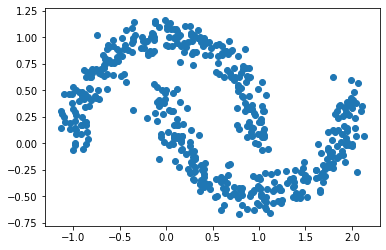

In [577]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:,0], X[:,1])
plt.show()

Кластеризуйте это с помощью своей версии DBSCAN:

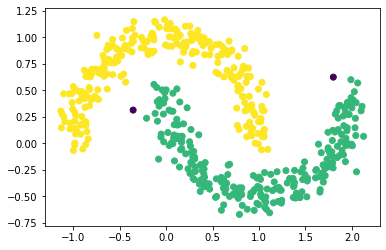

In [578]:
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Референс:

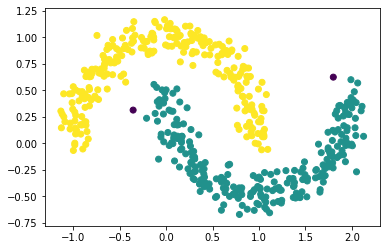

In [582]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Получите 1 балл за ещё один интересный пример кластеризации (в качестве референса используйте предоставленное изображение. Нужно несколько интересных соседствующих форм):

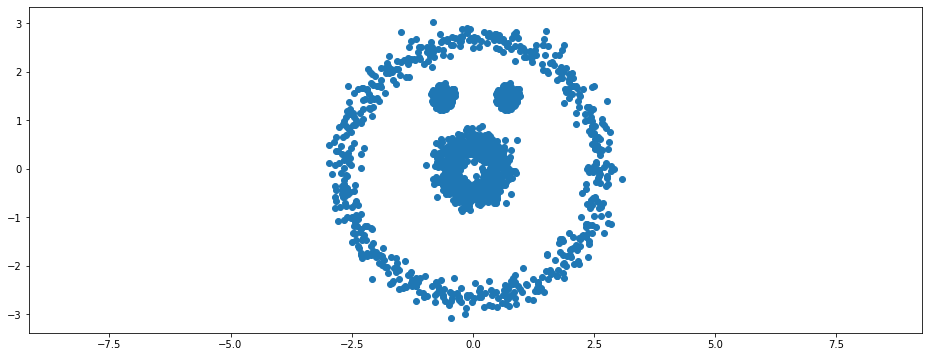

In [575]:
from sklearn.datasets import make_blobs
from sklearn.datasets import make_circles

plt.figure(figsize=(16, 6))

X1, _ = make_circles(n_samples=1200, factor=0.2, noise=0.06)
transformation = [[8, 0], [0, 8]]
X1 = np.dot(X1, transformation)
X3, _ = make_blobs(n_samples=200, centers=1, random_state=178)
transformation = [[1/3, 0], [0, 1/3]]
X3 = np.dot(X3, transformation)+[2, 7.5]
X4, _ = make_blobs(n_samples=200, centers=1, random_state=178)
transformation = [[1/3, 0], [0, 1/3]]
X4 = np.dot(X4, transformation)+[-2, 7.5]
X = np.concatenate((X1, X3, X4), axis=0)
transformation = [[1/3, 0], [0, 1/3]]
X = np.dot(X, transformation)
plt.scatter(X[:,0], X[:,1])
plt.axis('equal') 
plt.show()

Вроде очень красиво и похоже на медведя или собаку из мемов.

мне кажется, картинка крутится

Получите ещё 1 балл, если время работы вашего алгоритма больше референсного не более чем в 100 раз с учётом погрешности 3% от вашего времени:

In [596]:
%%time
%%capture
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

Wall time: 13 ms


In [603]:
%%time
%%capture
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

Wall time: 3.03 s


мне кажется, у меня отличный алгоритм и я очень страдала...